# Practical Assignment 6

In this assignment a GAN is trained on the MNIST dataset. The MNIST dataset (provided by Yann Lecun) consists of handwritten digits of which an example is shown in figure 1. 

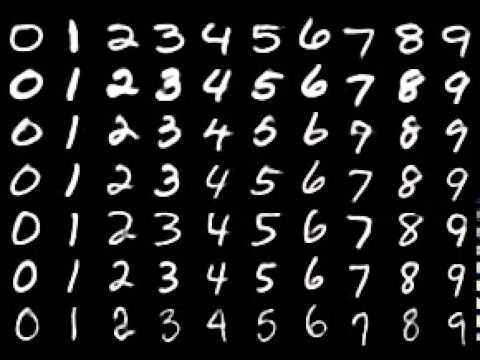

Figure 1: An example of the MNIST dataset

#### Imports

In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from utils import RandomIterator, get_mnist # as provided in the course
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

####  Defining the network
In the class below the structure of the generator (GAN) is defined and a classifier wrapper is defined


In [2]:
class Generator(Chain):
    def __init__(self):
        super(Generator, self).__init__()
        with self.init_scope():
            self.l1 = L.Linear(None, 28*28)
            self.b1 = L.BatchNormalization(28 * 28 * 255)
            self.d1 = L.Deconvolution2D(None, None, outsize=(28, 28))
            
    def __call__(self, x):
        h = F.relu(self.l1(x))
        h = F.sigmoid(self.b1(h))
        output = F.sigmoid(self.d1(h))
        return output
    
    def gen(self): 
        return np.random.random_sample((28, 28))
    
class Classifier(Chain):
    """
    
    Classifier chain on top of Neural Network chain 
    for accuracy evaluation and prediction
    
    """
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
    
    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        report({'loss': loss, 'accuracy': accuracy}, self)
        return loss

In the class below the structure of the discriminator (GAN) is defined and a classifier wrapper is defined. 

In [3]:
class Discriminator(Chain):
    def __init__(self):
        super(Discriminator, self).__init__()
        with self.init_scope():
            self.conv1 = L.Convolution2D(in_channels=None, out_channels=5, ksize=5, stride=1, pad=0)
            self.l1 = L.Linear(None, 1)
        
    def __call__(self, x):
        h = F.relu(self.conv1(x))
        output = F.sigmoid(self.l1(h))
        return output
    
class Classifier(Chain):
    """
    
    Classifier chain on top of Neural Network chain 
    for accuracy evaluation and prediction
    
    """
    def __init__(self, predictor):
        super(Classifier, self).__init__()
        with self.init_scope():
            self.predictor = predictor
    
    def __call__(self, x, t):
        y = self.predictor(x)
        loss = F.softmax_cross_entropy(y, t)
        accuracy = F.accuracy(y, t)
        report({'loss': loss, 'accuracy': accuracy}, self)
        return loss

#### Training set creation

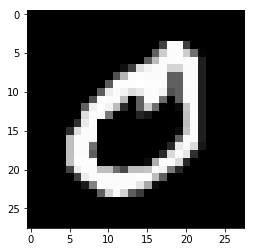

In [4]:
# Retrieve train & test data      
train_data, test_data = get_mnist(n_train=1000, n_test=100, with_label=False, classes=[0])
plt.imshow((train_data[1][0]), cmap='gray')

#### Implement the training & test loop


In [5]:
dis = Discriminator()
classifier_dis = Classifier(dis)
optimizer_dis = optimizers.Adam()
optimizer_dis.setup(classifier_dis)

gen = Generator()
classifier_gen = Classifier(gen)
optimizer_gen = optimizers.Adam()
optimizer_gen.setup(classifier_gen)

In [ ]:
epochs = 20
ri = RandomIterator(train_data, 1)
for x in range(epochs):
    for batch in ri:
        x = batch[0][0].astype('float32')
        z = gen.gen().astype('float32')
        classifier_dis.cleargrads()
        loss = F.sum(classifier_dis(x, z)) 
        optimizer_gen.update()
        optimizer_dis.update()
        #after this instructions are not so clear to me anymore..

#### Plotting training and test loss versus epoch